In [10]:
%load_ext nb_black
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use("fast")
import numpy as np
from IPython.display import set_matplotlib_formats, SVG

set_matplotlib_formats("svg")
import msprime as msp

<IPython.core.display.Javascript object>

# Lecture 8
## Selective sweeps and hitchhiking

If we think back to last week when we studied recombination, we saw that two genes evolve as:

#### No recombination
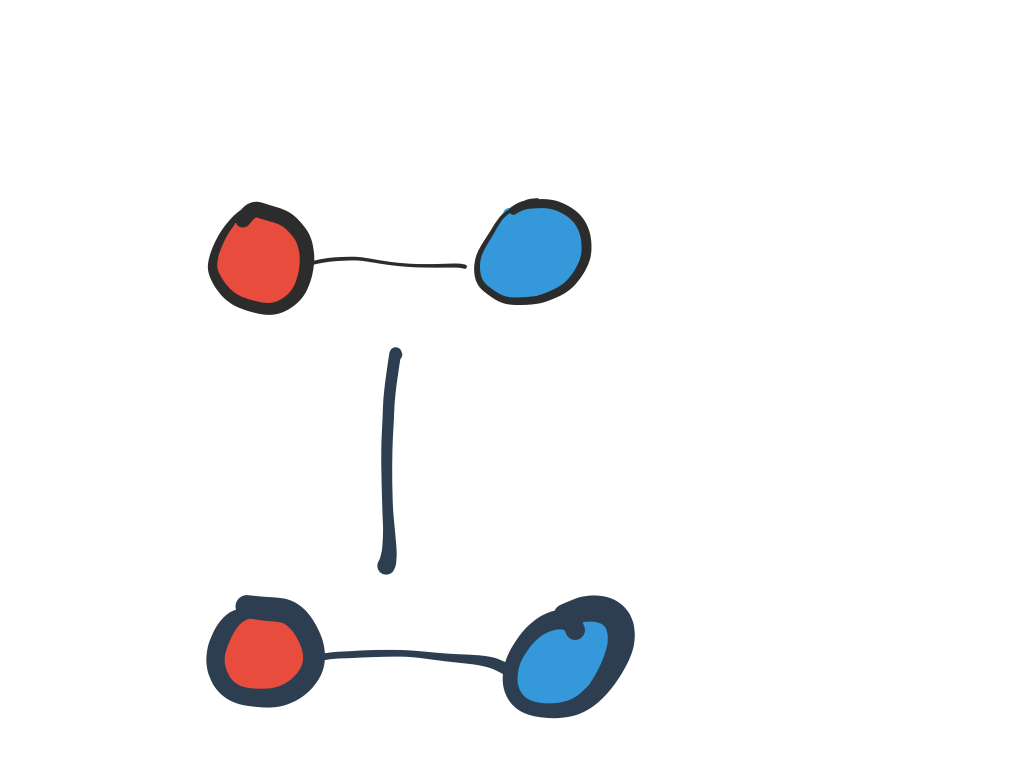

#### Recombination
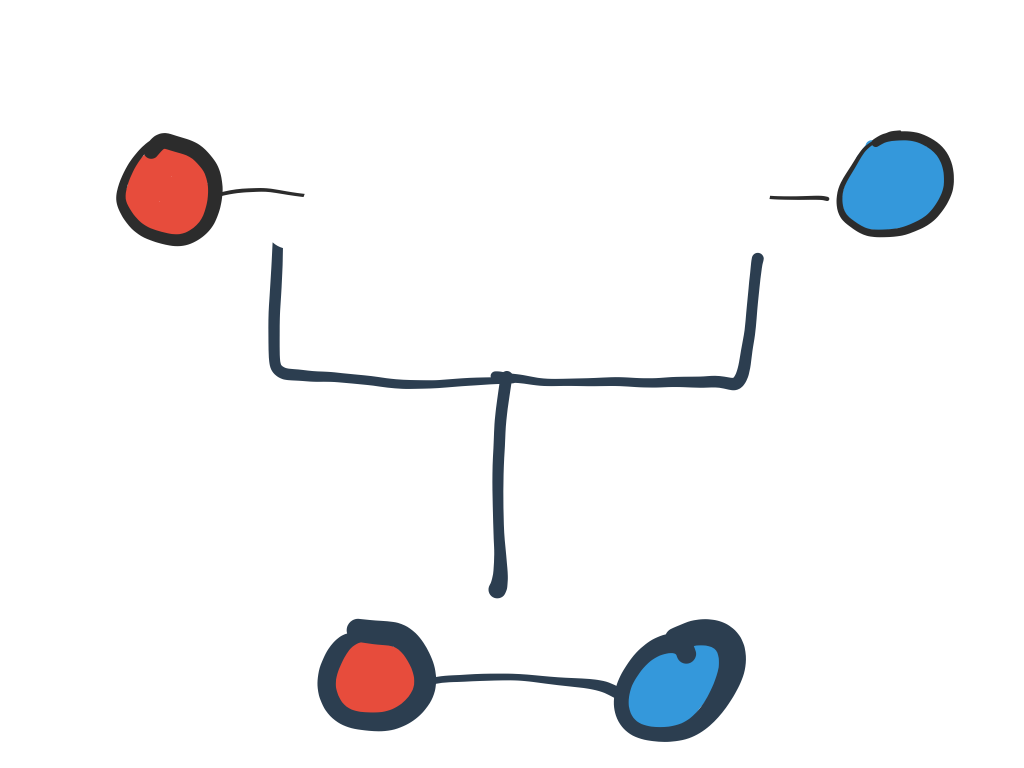

What would happen if the blue gene suddenly acquired a selective advantage?

### Hitchhiking
This phenomenon is called [genetic hitchhiking](https://en.wikipedia.org/wiki/Genetic_hitchhiking). When a favorable allele arises in the population, it will sweep to fixation. Alleles at nearby loci will "hitchhike" and also increase in frequency.

To model this effect, we will suppose that the red gene is neutral with types $A$ and $a$, while the blue gene suddenly acquires a beneficial variant $B$ (with recessive type $b$). So the possible genotypes are $AB$, $Ab$, $aB$, and $aa$.

We will suppose that the frequency of the $B$ allele in the population, $p_t$, follows the ODE

$$\frac{dp_t}{dt} = sp_t(1-p_t).$$

This is just the logistic equation, with solution

$$p_t = \frac{p_0}{p_0 + (1-p_0)e^{-st}}$$.

For later use, let $\tau$ be the time at which $p_\tau=1/2$ when $p_0=\epsilon$. That is, $\tau$ solves 

$$\left(\frac{1-\epsilon}{\epsilon}\right)e^{-s\tau}=1.$$

Note that, by symmetry, $p_{2\tau}=1-\epsilon$.

**Theorem**. Let $Q_t=P(A|B)$ be the fraction of $A$ alleles in the $B$ population at time $t$, and similarly $R_t=P(A|b)$. Assuming $Q_0=0$, the frequency of the $A$ allele after the sweep is 

$$Q_\infty = R_0(1-p_0) \int_0^{2\tau} \frac{re^{-rt}}{(1-p_0)+p_0e^{st}}dt.$$

(Note that $R_0(1-p_0)$ is the frequency of $A$ before the sweep.)

*Proof*. Let $v(t)$ (resp. $w(t)$) be the frequency of the $A$ allele in the population of $B$ (resp. $b$) genes at time $t$. Recombinations convert $Ab$ genotypes to $AB$ at rate $r(1-p_t)w(t)$ and $AB\to Ab$ at rate $rp_tv(t)$. Thus
\begin{align}
\frac{dv}{dt} &= r(1-p_t)(w(t)-v(t)) \\
\frac{dw}{dt} &= rp_t(v(t)-w(t))
\end{align}


This can be rearranged to 

$$\frac{d}{dt} (v(t)-w(t)) = -r(v(t)-w(t))$$

which has the simple solution

$$v(t) - w(t) = e^{-rt}(v(0) - w(0)).$$

With $\tau$ defined as above, we can eliminate $w(t)$ in the equation for $dv/dt$ to get 

$$\frac{dv}{dt} = Cr(1-p_t)e^{-rt}$$ 

where $C=w(0)-v(0)=R_0$.

Integrating both sides and substituting for $p_t$, we get 

$$v(2\tau)=R_0(1-p_0) \int_0^{2\tau} \frac{re^{-rt}}{1-p_0+p_0e^{st}}dt.$$

**Corollary**. If $N\to\infty$ such that $r\log (2N) /s \to a$ then 

$$v_1(2\tau)\to1- e^{-a}$$.

*Proof*. See Durrett Theorem 6.14.

This says that if $r\approx s$ then hitchhiking will have a minimal impact. However, if $r\ll s$ then $v_1(2\tau)$ will be substantially 

## Measures of diversity: Tajima's $\pi$
In the region of a selected gene, hitchhiking will tend to reduce genetic diversity. We can measure this by looking at the number of pairwise differences in the sample. Let $D_{ij}$ be the fraction of mismatches between samples $i$ and $j$. (For example, if sequence $1$ is `GATTACAGATTACA` and sequence $2$ is `CATTACACATTACA`, then $D_{ij}=2$.) We define 

$$\theta_\pi = \frac{1}{\binom{n}{2}} \sum_{i<j} D_{ij}$$

Note that $\mathbb{E}\theta_\pi = \theta$, the population-scaled mutation rate.

## Real data example
Now we will see an example of hitchhiking in real data.

In [5]:
# import tskit
# chr2 = tskit.load('/scratch/1kg/trees/1kg_chr2.trees')

In [19]:
with open("integrated_call_samples_v3.20130502.ALL.panel", "rt") as f:
    next(f)
    rows = (line.strip().split("\t") for line in f)
    sample_map = {sample_id: (pop, superpop) for sample_id, pop, superpop, _ in rows}

# map each 1kg sample id ts nodes
import json

samples_to_nodes = {
    json.loads(ind.metadata)["individual_id"]: ind.nodes for ind in chr2.individuals()
}

superpops = {}
for sample_id, (p, sp) in sample_map.items():
    superpops.setdefault(sp, [])
    superpops[sp].append(samples_to_nodes[sample_id])

for sp in superpops:
    superpops[sp] = np.concatenate(superpops[sp]).reshape(-1)

<IPython.core.display.Javascript object>

In [17]:
# chr2_130 = chr2.keep_intervals([[130_000_000, 140_000_000]], simplify=False).trim()
# chr2_130.dump("chr2_130.trees")
chr2_130 = tskit.load("chr2_130.trees")

<IPython.core.display.Javascript object>

In [8]:
win = np.linspace(0, 10_000_000, 10_000_000 // 200_000)
ss = [superpops[sp][:20] for sp in superpops]
pi = chr2_130.diversity(windows=win, sample_sets=ss)

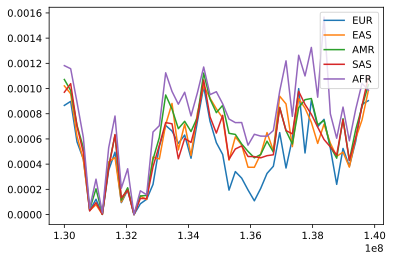

<IPython.core.display.Javascript object>

In [20]:
for p, sp in zip(pi.T, superpops):
    plt.plot(130_000_000 + win[:-1], p, label=sp)
    # plt.yscale("log")
    plt.legend()

The what is the gene at approximately position $1.36\times 10^8?$ If you didn't know, you could try using the [genome browser](https://www.ncbi.nlm.nih.gov/genome/gdv/browser/gene/?id=3553) to find out.